# Preparation


In [82]:
import math

from time import time
import datetime

import pandas as pd
import numpy as np
import quandl

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

## Data Cleaning

In [14]:
df = pd.read_csv('tesla.csv')
df.index = df['Date']
df = df.sort_index(ascending = True, axis = 0)

In [34]:
df.head()

,Date,Date.1,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,...,Adj. Volume,ds,y,Daily Change,Year,Month,Week,Day,Dayofweek,Dayofyear
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,2012-01-03,2012-01-03,28.94,29.50,27.65,28.08,928100.0,0.0,1.0,28.94,...,928100.0,2012-01-03,28.08,-0.86,2012,1,1,3,1,3
2012-01-04,2012-01-04,2012-01-04,28.21,28.67,27.50,27.71,630100.0,0.0,1.0,28.21,...,630100.0,2012-01-04,27.71,-0.50,2012,1,1,4,2,4
2012-01-05,2012-01-05,2012-01-05,27.76,27.93,26.85,27.12,1005500.0,0.0,1.0,27.76,...,1005500.0,2012-01-05,27.12,-0.64,2012,1,1,5,3,5
2012-01-06,2012-01-06,2012-01-06,27.20,27.79,26.41,26.91,986300.0,0.0,1.0,27.20,...,986300.0,2012-01-06,26.91,-0.29,2012,1,1,6,4,6
2012-01-09,2012-01-09,2012-01-09,27.00,27.49,26.12,27.25,897000.0,0.0,1.0,27.00,...,897000.0,2012-01-09,27.25,0.25,2012,1,2,9,0,9


## Define function

In [29]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), t_train), rmse(m.predict(X_val), t_val),
                m.score(X_train, t_train), m.score(X_val, t_val)]
    print(f"rmse train {res[0]}, rmse val {res[1]}, r^2 train {res[2]}, r^2 val {res[3]}")

# Random Forest

## Try to predict using a Single Decision Tree

In [30]:
df.columns

Index(['Date', 'Date.1', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low',
       'Adj. Close', 'Adj. Volume', 'ds', 'y', 'Daily Change', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear'],
      dtype='object')

In [31]:
n_total = df.count()[0]
n_valid = 180 # Six months
n_train = n_total - n_valid

# In this case, I would like to predict the stock price by using OLHC Data
features = ['Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Close']
df_small = df
X_df = df_small[features]
t_df = df_small['y']

X_train, X_val = X_df[:n_train].to_numpy(), X_df[n_train:].to_numpy()
t_train, t_val = t_df[:n_train].to_numpy(), t_df[n_train:].to_numpy()

In [32]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 1, bootstrap = True, min_samples_leaf = 25)
model.fit(X_train, t_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=25,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [33]:
print_score(model)

rmse train 5.150626113476439, rmse val 4.382942883692601, r^2 train 0.9965165047631718, r^2 val 0.9729952809567858


In [37]:
model.estimators_[0].get_depth()

6

The result is not bad, *RMSE* is pretty low and $R^2$ is close to 1. 

This random forest is a single decision tree with depth of 6 and at least 25 samples in each leaf node. We enabled bootstrapping to avoid overfitting. 

I believe the model could be optimized using Random Forest, as it it constructed by some decision trees using bagging.

## Try Random Forest

In [39]:
model = RandomForestRegressor(n_estimators=40, bootstrap=True, min_samples_leaf=25)
model.fit(X_train, t_train)

print_score(model)

rmse train 3.9034098186634734, rmse val 2.4245026785986763, r^2 train 0.9979992930963252, r^2 val 0.9917367027160658


We see a slight improvement in *RMSE* and $R^2$ for both training and validation data. It is a better model!

Now let's try to plot out our prediction.

In [54]:
np.mean(model.predict(X_val)), np.mean(t_val)

(221.6080401416136, 222.1485555555556)

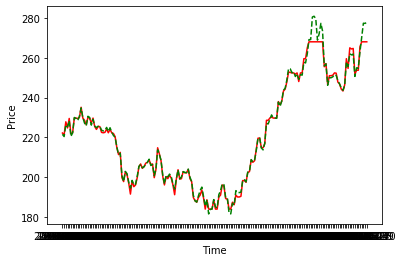

In [52]:
plt.plot(df_small['Date'][n_train:], model.predict(X_val), 'r-')
plt.plot(df_small['Date'][n_train:], t_val, 'g--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

## Try to use GridSearch for model selection

In [59]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [30, 40, 50, 60],
    'min_samples_leaf': [20, 25, 30, 40]
}

rf = RandomForestRegressor(bootstrap = True)
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, t_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [61]:
clf.best_params_

{'min_samples_leaf': 20, 'n_estimators': 40}

In [77]:
best_model = RandomForestRegressor(n_estimators = 40, bootstrap = True, min_samples_leaf = 20)
best_model.fit(X_train, t_train)
print_score(best_model)

rmse train 154.7236114644389, rmse val 196.61044864752793


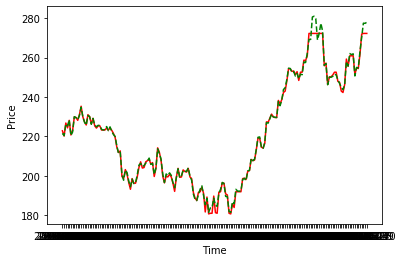

In [78]:
plt.plot(df_small['Date'][n_train:], best_model.predict(X_val), 'r-')
plt.plot(df_small['Date'][n_train:], t_val, 'g--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

This model is another great improvement. This tells us the importance of trying different parameters in order to get a better model.

# KNN

Lastly, we will try K-nearest neighbors to predict the stock price.

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# It is important to scale the data for kNN
scaler = MinMaxScaler(feature_range = (0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [68]:
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, params, cv = 5)

clf.fit(X_train_scaled, t_train)
clf.best_params_

{'n_neighbors': 2}

In [79]:
best_model = KNeighborsRegressor(n_neighbors = 2)
best_model.fit(X_train_scaled, t_train)

def print_score(m):
    res = [rmse(m.predict(X_train_scaled), t_train), rmse(m.predict(X_val_scaled), t_val)]
    print(f"rmse train {res[0]}, rmse val {res[1]}")

In [80]:
print_score(best_model)

rmse train 0.596753984777006, rmse val 100.14868004648451


It seems that K-nearest neighbors is not a good algorithm for predicting this dataset. It is a highly overfitting model. Random Forest is a better choice. 